# BlackJack : Monte-Carlo with Exploring Start
----

## 설명
블랙잭 게임에서의 최적 Policy를 찾는 프로그램입니다. 본 프로그램에서 정의된 블랙잭 룰은 다음과 같습니다.
 - 하나의 카드 덱(조커를 제외한 52장의 카드)을 사용
 - 카드의 합을 계산할 시 A = 1 or 11, J,Q,K = 10으로 계산
 - 플레이어는 Hit 또는 Stick만을 할 수 있음
 - 카드의 합이 21 이하일 경우, 딜러와 플레이어 중 숫자가 더 높은 쪽이 승리.
 - 카드의 합이 21 초과한 딜러/플레이어는 패배
 - 카드의 합이 같을 경우 무승부

본 프로그램에서는 최적 Policy를 찾기 위해 Monte-Carlo Control with Exploring Start[1] 알고리즘을 사용합니다. 최적 Policy를 찾기 위해, 본 프로그램은 다음과 같은 변수로 구성된 State로부터 탐색을 수행합니다.
 - 플레이어 카드의 합 : 12 ~ 21 사이의 정수
 - 딜러가 보여주는 카드의 숫자 : 1 ~ 10 사이의 정수
 - 플레이어가 현재 사용 가능한 Ace의 유무 : True / False

위와 같이 구성된 State S에서 Action A를 선택했을 때의 기대 리턴(게임이 끝났을 때 얻을 것으로 기대되는 보상의 합)은 Q(S,A)입니다. 많은 에피소드를 경험할수혹 Agent는 Optimal Q(S,A)에 가까운 값을 학습하게 되며, 이로부터 최적 Policy를 찾을 수 있습니다.

----

## 0. Package
먼저 본 프로그램에서 사용할 Package를 Import합니다.

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## 1. Class : Deck
카드 덱 한 벌에 해당하는 클래스를 선언합니다. 조커를 제외한 52장의 카드로 이루어져 있으며, 각 카드는 정수로 표기됩니다. <br>
A = 11, J, Q, K = 10으로 표현되며, 나머지 카드는 해당 카드에 적힌 숫자만큼의 값을 갖습니다.

### 클래스 구성
* Attributes
   * card_deck : List, 52개의 정수로 이루어짐
* Methods
   * shuffle() : 카드 덱을 랜덤하게 섞음
   * draw() : 카드 덱에서 한 장을 뽑아 리턴
   * reset() : 카드 덱을 초기화함

In [2]:
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """

    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        return self.card_deck.pop()

    def reset(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

## 2. Class : Dealer
다음으로 Dealer 클래스를 선언합니다.<br> 
Dealer 클래스는 강화학습에서의 Environment에 해당합니다. 플레이어의 Action을 받고, 그에 따른 다음 State와 Reward를 반환합니다.<br>
딜러는 시작할 때 두 장의 카드를 받습니다. 플레이어의 차례가 끝난 후, 플레이어의 카드 합이 21을 넘지 않는다면 딜러는 다음과 같이 행동합니다.
 - 딜러 카드의 합이 17 미만일 때 : 카드 한 장을 추가로 뽑음 (Hit)
 - 딜러 카드의 합이 17 이상일 때 : 플레이어의 카드 합과 비교하여 승패 결정 (Stick)

### 클래스 구성
딜러 클래스는 다음과 같이 구성됩니다
 - Attributes
     - hands : List, 딜러가 가지고 있는 카드들
     - usable_ace : List, 딜러가 가지고 있는 A의 인덱스
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - show() : 딜러가 가진 카드 중 랜덤한 한 장의 값을 리턴
     - calculate_sum() : 딜러가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - action() : 딜러의 Action - 합이 17 미만이면 hit, 이상이면 stick
     - observation(action, agent, deck) : 플레이어의 action을 받아 종료 여부와 reward 리턴
     - calculate_rewards(agent, deck) : 플레이어와 딜러의 승패 계산 및 reward 리턴
     - reset() : 딜러 클래스의 모든 attribute 초기화

In [3]:
class Dealer(object):
    """
    Dealer : 딜러 클래스
    딜러는 두 장의 카드를 받고, 카드의 합이 16 이하이면 Hit, 17이상이면 Stick 함.
    처음 두 장을 받았을 때 한 장의 카드를 랜덤하게 오픈함.
    """

    def __init__(self):
        """
        hand : 딜러가 가진 카드
        usable_ace : 딜러가 가진 카드 리스트 중 ace의 인덱스
        natural : 두 장의 카드로 21이 되면 True, 아니면 False
        """
        self.hands = list()
        self.usable_ace = list()

    def hit(self, deck: Deck):
        """
        딜러의 Hit. 새로운 카드가 Ace라면 사용 가능한 Ace 리스트에 추가함
        :param deck: Deck Object
        :return:
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def show(self):
        """
        딜러가 가진 카드 중 하나를 랜덤하게 보여줌
        :return: 딜러의 카드 중 랜덤한 카드 숫자
        """
        card = random.choice(self.hands)
        if card == 11:
            card = 1
        return card

    def calculate_sum(self):
        """
        딜러가 가진 카드의 합을 구함
        21을 넘을 때 사용 가능한 Ace가 있으면 사용함
        :return: 딜러 카드의 합
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def action(self, deck: Deck):
        """
        딜러의 순서 때 딜러의 행동.
        숫자의 합이 16 이하일 때는 Hit, 17 이상이면 Stick
        :param deck:
        :return:
        """
        while True:
            sums = self.calculate_sum()
            if sums < 17:
                self.hit(deck)
            else:
                return sums

    def observation(self, action, agent, deck):
        """
        플레이어의 Action을 받아, 그에 맞는 Observation과 Reward를 반환
        :param action: agent 의 Action
        :param agent: agent 클래스
        :param deck: deck 클래스
        :return: 에피소드 종료 여부, reward
        """
        done = False
        reward = 0
        if action == True:  # Hit
            agent.hit(deck)
            if agent.calculate_sum() > 21:  #플레이어의 Hit으로 인해 카드 합이 21이 넘으면 즉시 종료
                done = True
                reward = -1
        else:  # Stick
            done = True
            reward = self.calcuate_reward(agent, deck)

        return done, reward

    def calcuate_reward(self, agent, deck):
        """
        플레이어가 Stick했을 때 딜러와의 카드 비교 수행
        :param agent:
        :param deck:
        :return: Reward
        """
        agent_sum = agent.calculate_sum()           # 플레이어의 카드 합 계산
        if agent_sum > 21:                          # 플레이어의 Bust (패)
            return -1

        dealer_sum = self.action(deck)              # 딜러의 카드 합 계산
        if dealer_sum > 21:                         # 딜러가 Bust (승)
            return 1
        if dealer_sum > agent_sum:                  # 딜러의 카드 합 > 플레이어 합 (패)
            return -1
        if dealer_sum < agent_sum:                  # 딜러의 카드 합 < 플레이어 합 (승)
            return 1
        return 0                                   # 딜러의 카드 합 == 플레이어의 합 (무)

    def reset(self):
        """
        딜러 초기화 (새로운 에피소드 시작을 위해)
        """
        self.hands = list()
        self.usable_ace = list()

## 3. Class : Agent
Agent 클래스는 플레이어에 해당하며, 최적 Policy를 학습하는 주체가 됩니다. Agent는 여러 에피소드들로부터 Q값(기대 Return)을 계산하고, 다음 에피소드 수행 시 해당 State에서 Q값이 높은 Action을 선택하는 Greedy Policy를 따릅니다. 

### 클래스 구성

Agent의 구성은 다음과 같습니다.

 - Attributes
     - hands : List, Agent가 가지고 있는 카드들
     - usable_ace : List, Agent가 가지고 있는 A의 인덱스
     - Q_table : Dictionary, 기대 Return값과 방문 횟수를 저장
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - calculate_sum() : Agent가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - random_action() : 현재 State에 상관없이 랜덤하게 Action을 리턴
     - policy(state) : 현재 State에서 가능한 Action 중, Q_table의 값이 큰 Action을 리턴
     - update_qval(episode) : 에피소드로부터 평균 리턴을 계산하여 Q_table을 업데이트
     - reset() : Agent 클래스의 모든 attribute 초기화

In [4]:
class Agent(object):
    def __init__(self):
        """
        hand : 플레이어의 카드
        usable_ace : 사용 가능한 ace 리스트
        Q_table : q(s,a) 값을 저장할 딕셔너리
        """
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()

    def hit(self, deck: Deck):
        """
        덱에서 새로운 카드를 뽑음
        :param deck: Deck for draw a card
        :return: None
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def calculate_sum(self):
        """
        플레이어가 가진 카드의 합을 구함.
        21을 넘을 때 사용 가능한 ace가 있으면 사용함
        :return:
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def random_action(self):
        """
        랜덤하게 행동
        True = hit, False = stick
        :return:
        """
        return random.choice([True, False])

    def policy(self, state):
        """
        Agent의 policy 함수.
        e의 확률로 랜덤 행동을 하며, 그 외에는 현재 state에서 큰 q(s,a)값을 갖는 action을 선택함
        :param state: Agent에게 주어진 state
        :return: agent의 action을 반환 , True = hit and False = stick
        """
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in (True, False):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue

        # q값이 큰 action 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)]:
            return True     # Hit
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)]:   # q값이 같으면 무작위추출
            return self.random_action()
        else:
            return False    # Stick


    def reset(self):
        """
        Agent를 리셋함
        :return: None
        """
        self.hands = list()
        self.usable_ace = list()

    def update_qval(self, episode):
        """
        에피소드(한 번의 게임)으로부터 Q_table 을 업데이트함
        Q 테이블에 없는 state-action 쌍이 나오면 새로 생성
        Q 테이블에 state-action 쌍이 존재한다면 Incremental mean 적용하여 업데이트
        :param episode: Episode generated from environment
        :return: None
        """
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트

## 4. Class : MonteCarlo
Monte-Carlo control with Exploring Start를 구현한 클래스입니다. 에피소드를 생성할 수 있고, 생성된 에피소드로부터 에이전트를 학습시킵니다.
에피소드 생성 시 Exploring Start를 위해 에피소드의 첫 번째 State에서는 무작위로 Action을 선택하며, 이후에는 에이전트의 Policy를 따라 Action을 선택합니다.

### 클래스 구성
MonteCarlo 클래스는 다음과 같이 구성됩니다.
 - Attribute
     - 없음
 - Methods 
     - generate_episode(dealer, agent, deck) : 딜러, 플레이어, 카드 덱을 이용해 한 번의 블랙잭 게임을 진행하고 에피소드를 반환합니다.
     - train(dealer, agent, deck, it, verbose) : 지정된 이터레이션 수만큼의 에피소드로부터 플레이어를 학습시킵니다.

In [5]:
class MonteCarlo(object):
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            state = (sums, bool(agent.usable_ace), dealer.show())

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action =agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        return episode

    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it=10000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
                

## 5. Function : plot_q_val(agent, usable_ace)
Q값을 시각화하기 위한 함수입니다.

In [6]:
def plot_q_val(agent: Agent, usable_ace=True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

## 6. Function : plot_q_val(agent, usable_ace)
최적 Policy를 시각화하기 위한 함수입니다.

In [7]:
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.show()
    return X, Y, Z

## 7. 최적 Policy 학습


In [8]:
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it=1000000)

========== Training : Episode  1000  ===========
Recent 1000 games win rate :34.421%
 -- 1000 Games WIN : 327 DRAW : 50 LOSS : 623
Total win rate : 34.421%
 -- TOTAL Games WIN : 327 DRAW : 50 LOSS : 623
========== Training : Episode  2000  ===========
Recent 1000 games win rate :35.638%
 -- 1000 Games WIN : 335 DRAW : 60 LOSS : 605
Total win rate : 35.026%
 -- TOTAL Games WIN : 662 DRAW : 110 LOSS : 1228
========== Training : Episode  3000  ===========
Recent 1000 games win rate :36.229%
 -- 1000 Games WIN : 342 DRAW : 56 LOSS : 602
Total win rate : 35.427%
 -- TOTAL Games WIN : 1004 DRAW : 166 LOSS : 1830
========== Training : Episode  4000  ===========
Recent 1000 games win rate :35.638%
 -- 1000 Games WIN : 335 DRAW : 60 LOSS : 605
Total win rate : 35.480%
 -- TOTAL Games WIN : 1339 DRAW : 226 LOSS : 2435
========== Training : Episode  5000  ===========
Recent 1000 games win rate :34.989%
 -- 1000 Games WIN : 331 DRAW : 54 LOSS : 615
Total win rate : 35.381%
 -- TOTAL Games WIN : 16

========== Training : Episode  42000  ===========
Recent 1000 games win rate :33.616%
 -- 1000 Games WIN : 317 DRAW : 57 LOSS : 626
Total win rate : 35.119%
 -- TOTAL Games WIN : 13869 DRAW : 2508 LOSS : 25623
========== Training : Episode  43000  ===========
Recent 1000 games win rate :37.714%
 -- 1000 Games WIN : 353 DRAW : 64 LOSS : 583
Total win rate : 35.179%
 -- TOTAL Games WIN : 14222 DRAW : 2572 LOSS : 26206
========== Training : Episode  44000  ===========
Recent 1000 games win rate :36.645%
 -- 1000 Games WIN : 343 DRAW : 64 LOSS : 593
Total win rate : 35.212%
 -- TOTAL Games WIN : 14565 DRAW : 2636 LOSS : 26799
========== Training : Episode  45000  ===========
Recent 1000 games win rate :35.383%
 -- 1000 Games WIN : 328 DRAW : 73 LOSS : 599
Total win rate : 35.216%
 -- TOTAL Games WIN : 14893 DRAW : 2709 LOSS : 27398
========== Training : Episode  46000  ===========
Recent 1000 games win rate :34.118%
 -- 1000 Games WIN : 319 DRAW : 65 LOSS : 616
Total win rate : 35.192%
 --

========== Training : Episode  82000  ===========
Recent 1000 games win rate :36.186%
 -- 1000 Games WIN : 334 DRAW : 77 LOSS : 589
Total win rate : 35.158%
 -- TOTAL Games WIN : 27126 DRAW : 4845 LOSS : 50029
========== Training : Episode  83000  ===========
Recent 1000 games win rate :36.803%
 -- 1000 Games WIN : 343 DRAW : 68 LOSS : 589
Total win rate : 35.177%
 -- TOTAL Games WIN : 27469 DRAW : 4913 LOSS : 50618
========== Training : Episode  84000  ===========
Recent 1000 games win rate :37.607%
 -- 1000 Games WIN : 352 DRAW : 64 LOSS : 584
Total win rate : 35.206%
 -- TOTAL Games WIN : 27821 DRAW : 4977 LOSS : 51202
========== Training : Episode  85000  ===========
Recent 1000 games win rate :35.593%
 -- 1000 Games WIN : 336 DRAW : 56 LOSS : 608
Total win rate : 35.211%
 -- TOTAL Games WIN : 28157 DRAW : 5033 LOSS : 51810
========== Training : Episode  86000  ===========
Recent 1000 games win rate :35.962%
 -- 1000 Games WIN : 342 DRAW : 49 LOSS : 609
Total win rate : 35.220%
 --

========== Training : Episode  123000  ===========
Recent 1000 games win rate :33.759%
 -- 1000 Games WIN : 317 DRAW : 61 LOSS : 622
Total win rate : 35.164%
 -- TOTAL Games WIN : 40685 DRAW : 7298 LOSS : 75017
========== Training : Episode  124000  ===========
Recent 1000 games win rate :33.228%
 -- 1000 Games WIN : 314 DRAW : 55 LOSS : 631
Total win rate : 35.148%
 -- TOTAL Games WIN : 40999 DRAW : 7353 LOSS : 75648
========== Training : Episode  125000  ===========
Recent 1000 games win rate :35.983%
 -- 1000 Games WIN : 335 DRAW : 69 LOSS : 596
Total win rate : 35.155%
 -- TOTAL Games WIN : 41334 DRAW : 7422 LOSS : 76244
========== Training : Episode  126000  ===========
Recent 1000 games win rate :36.797%
 -- 1000 Games WIN : 347 DRAW : 57 LOSS : 596
Total win rate : 35.168%
 -- TOTAL Games WIN : 41681 DRAW : 7479 LOSS : 76840
========== Training : Episode  127000  ===========
Recent 1000 games win rate :35.152%
 -- 1000 Games WIN : 335 DRAW : 47 LOSS : 618
Total win rate : 35.167

========== Training : Episode  167000  ===========
Recent 1000 games win rate :34.424%
 -- 1000 Games WIN : 326 DRAW : 53 LOSS : 621
Total win rate : 35.115%
 -- TOTAL Games WIN : 55154 DRAW : 9931 LOSS : 101915
========== Training : Episode  168000  ===========
Recent 1000 games win rate :39.957%
 -- 1000 Games WIN : 370 DRAW : 74 LOSS : 556
Total win rate : 35.143%
 -- TOTAL Games WIN : 55524 DRAW : 10005 LOSS : 102471
========== Training : Episode  169000  ===========
Recent 1000 games win rate :35.344%
 -- 1000 Games WIN : 334 DRAW : 55 LOSS : 611
Total win rate : 35.144%
 -- TOTAL Games WIN : 55858 DRAW : 10060 LOSS : 103082
========== Training : Episode  170000  ===========
Recent 1000 games win rate :37.821%
 -- 1000 Games WIN : 354 DRAW : 64 LOSS : 582
Total win rate : 35.160%
 -- TOTAL Games WIN : 56212 DRAW : 10124 LOSS : 103664
========== Training : Episode  171000  ===========
Recent 1000 games win rate :37.112%
 -- 1000 Games WIN : 347 DRAW : 65 LOSS : 588
Total win rate :

========== Training : Episode  206000  ===========
Recent 1000 games win rate :35.450%
 -- 1000 Games WIN : 335 DRAW : 55 LOSS : 610
Total win rate : 35.097%
 -- TOTAL Games WIN : 67985 DRAW : 12292 LOSS : 125723
========== Training : Episode  207000  ===========
Recent 1000 games win rate :34.567%
 -- 1000 Games WIN : 327 DRAW : 54 LOSS : 619
Total win rate : 35.094%
 -- TOTAL Games WIN : 68312 DRAW : 12346 LOSS : 126342
========== Training : Episode  208000  ===========
Recent 1000 games win rate :36.825%
 -- 1000 Games WIN : 348 DRAW : 55 LOSS : 597
Total win rate : 35.102%
 -- TOTAL Games WIN : 68660 DRAW : 12401 LOSS : 126939
========== Training : Episode  209000  ===========
Recent 1000 games win rate :36.179%
 -- 1000 Games WIN : 339 DRAW : 63 LOSS : 598
Total win rate : 35.108%
 -- TOTAL Games WIN : 68999 DRAW : 12464 LOSS : 127537
========== Training : Episode  210000  ===========
Recent 1000 games win rate :36.752%
 -- 1000 Games WIN : 344 DRAW : 64 LOSS : 592
Total win rate 

Recent 1000 games win rate :34.805%
 -- 1000 Games WIN : 331 DRAW : 49 LOSS : 620
Total win rate : 35.182%
 -- TOTAL Games WIN : 81705 DRAW : 14766 LOSS : 150529
========== Training : Episode  248000  ===========
Recent 1000 games win rate :36.073%
 -- 1000 Games WIN : 338 DRAW : 63 LOSS : 599
Total win rate : 35.186%
 -- TOTAL Games WIN : 82043 DRAW : 14829 LOSS : 151128
========== Training : Episode  249000  ===========
Recent 1000 games win rate :38.429%
 -- 1000 Games WIN : 362 DRAW : 58 LOSS : 580
Total win rate : 35.199%
 -- TOTAL Games WIN : 82405 DRAW : 14887 LOSS : 151708
========== Training : Episode  250000  ===========
Recent 1000 games win rate :37.080%
 -- 1000 Games WIN : 353 DRAW : 48 LOSS : 599
Total win rate : 35.206%
 -- TOTAL Games WIN : 82758 DRAW : 14935 LOSS : 152307
========== Training : Episode  251000  ===========
Recent 1000 games win rate :35.928%
 -- 1000 Games WIN : 337 DRAW : 62 LOSS : 601
Total win rate : 35.209%
 -- TOTAL Games WIN : 83095 DRAW : 14997 

========== Training : Episode  290000  ===========
Recent 1000 games win rate :35.199%
 -- 1000 Games WIN : 327 DRAW : 71 LOSS : 602
Total win rate : 35.211%
 -- TOTAL Games WIN : 95977 DRAW : 17420 LOSS : 176603
========== Training : Episode  291000  ===========
Recent 1000 games win rate :36.344%
 -- 1000 Games WIN : 342 DRAW : 59 LOSS : 599
Total win rate : 35.214%
 -- TOTAL Games WIN : 96319 DRAW : 17479 LOSS : 177202
========== Training : Episode  292000  ===========
Recent 1000 games win rate :35.075%
 -- 1000 Games WIN : 329 DRAW : 62 LOSS : 609
Total win rate : 35.214%
 -- TOTAL Games WIN : 96648 DRAW : 17541 LOSS : 177811
========== Training : Episode  293000  ===========
Recent 1000 games win rate :34.644%
 -- 1000 Games WIN : 326 DRAW : 59 LOSS : 615
Total win rate : 35.212%
 -- TOTAL Games WIN : 96974 DRAW : 17600 LOSS : 178426
========== Training : Episode  294000  ===========
Recent 1000 games win rate :35.684%
 -- 1000 Games WIN : 339 DRAW : 50 LOSS : 611
Total win rate 

========== Training : Episode  332000  ===========
Recent 1000 games win rate :35.101%
 -- 1000 Games WIN : 331 DRAW : 57 LOSS : 612
Total win rate : 35.262%
 -- TOTAL Games WIN : 110024 DRAW : 19979 LOSS : 201997
========== Training : Episode  333000  ===========
Recent 1000 games win rate :34.004%
 -- 1000 Games WIN : 321 DRAW : 56 LOSS : 623
Total win rate : 35.258%
 -- TOTAL Games WIN : 110345 DRAW : 20035 LOSS : 202620
========== Training : Episode  334000  ===========
Recent 1000 games win rate :36.374%
 -- 1000 Games WIN : 335 DRAW : 79 LOSS : 586
Total win rate : 35.261%
 -- TOTAL Games WIN : 110680 DRAW : 20114 LOSS : 203206
========== Training : Episode  335000  ===========
Recent 1000 games win rate :37.447%
 -- 1000 Games WIN : 355 DRAW : 52 LOSS : 593
Total win rate : 35.268%
 -- TOTAL Games WIN : 111035 DRAW : 20166 LOSS : 203799
========== Training : Episode  336000  ===========
Recent 1000 games win rate :37.766%
 -- 1000 Games WIN : 355 DRAW : 60 LOSS : 585
Total win r

========== Training : Episode  372000  ===========
Recent 1000 games win rate :34.428%
 -- 1000 Games WIN : 325 DRAW : 56 LOSS : 619
Total win rate : 35.301%
 -- TOTAL Games WIN : 123401 DRAW : 22435 LOSS : 226164
========== Training : Episode  373000  ===========
Recent 1000 games win rate :35.313%
 -- 1000 Games WIN : 333 DRAW : 57 LOSS : 610
Total win rate : 35.301%
 -- TOTAL Games WIN : 123734 DRAW : 22492 LOSS : 226774
========== Training : Episode  374000  ===========
Recent 1000 games win rate :37.794%
 -- 1000 Games WIN : 353 DRAW : 66 LOSS : 581
Total win rate : 35.308%
 -- TOTAL Games WIN : 124087 DRAW : 22558 LOSS : 227355
========== Training : Episode  375000  ===========
Recent 1000 games win rate :35.501%
 -- 1000 Games WIN : 333 DRAW : 62 LOSS : 605
Total win rate : 35.308%
 -- TOTAL Games WIN : 124420 DRAW : 22620 LOSS : 227960
========== Training : Episode  376000  ===========
Recent 1000 games win rate :33.333%
 -- 1000 Games WIN : 317 DRAW : 49 LOSS : 634
Total win r

 -- 1000 Games WIN : 351 DRAW : 51 LOSS : 598
Total win rate : 35.313%
 -- TOTAL Games WIN : 138044 DRAW : 25083 LOSS : 252873
========== Training : Episode  417000  ===========
Recent 1000 games win rate :35.470%
 -- 1000 Games WIN : 332 DRAW : 64 LOSS : 604
Total win rate : 35.313%
 -- TOTAL Games WIN : 138376 DRAW : 25147 LOSS : 253477
========== Training : Episode  418000  ===========
Recent 1000 games win rate :35.381%
 -- 1000 Games WIN : 334 DRAW : 56 LOSS : 610
Total win rate : 35.313%
 -- TOTAL Games WIN : 138710 DRAW : 25203 LOSS : 254087
========== Training : Episode  419000  ===========
Recent 1000 games win rate :33.193%
 -- 1000 Games WIN : 315 DRAW : 51 LOSS : 634
Total win rate : 35.308%
 -- TOTAL Games WIN : 139025 DRAW : 25254 LOSS : 254721
========== Training : Episode  420000  ===========
Recent 1000 games win rate :35.150%
 -- 1000 Games WIN : 329 DRAW : 64 LOSS : 607
Total win rate : 35.308%
 -- TOTAL Games WIN : 139354 DRAW : 25318 LOSS : 255328
========== Traini

 -- TOTAL Games WIN : 152733 DRAW : 27770 LOSS : 279497
========== Training : Episode  461000  ===========
Recent 1000 games win rate :36.881%
 -- 1000 Games WIN : 350 DRAW : 51 LOSS : 599
Total win rate : 35.339%
 -- TOTAL Games WIN : 153083 DRAW : 27821 LOSS : 280096
========== Training : Episode  462000  ===========
Recent 1000 games win rate :34.648%
 -- 1000 Games WIN : 325 DRAW : 62 LOSS : 613
Total win rate : 35.338%
 -- TOTAL Games WIN : 153408 DRAW : 27883 LOSS : 280709
========== Training : Episode  463000  ===========
Recent 1000 games win rate :38.280%
 -- 1000 Games WIN : 356 DRAW : 70 LOSS : 574
Total win rate : 35.344%
 -- TOTAL Games WIN : 153764 DRAW : 27953 LOSS : 281283
========== Training : Episode  464000  ===========
Recent 1000 games win rate :38.166%
 -- 1000 Games WIN : 358 DRAW : 62 LOSS : 580
Total win rate : 35.350%
 -- TOTAL Games WIN : 154122 DRAW : 28015 LOSS : 281863
========== Training : Episode  465000  ===========
Recent 1000 games win rate :37.140%
 

========== Training : Episode  505000  ===========
Recent 1000 games win rate :33.157%
 -- 1000 Games WIN : 314 DRAW : 53 LOSS : 633
Total win rate : 35.337%
 -- TOTAL Games WIN : 167656 DRAW : 30548 LOSS : 306796
========== Training : Episode  506000  ===========
Recent 1000 games win rate :34.258%
 -- 1000 Games WIN : 321 DRAW : 63 LOSS : 616
Total win rate : 35.335%
 -- TOTAL Games WIN : 167977 DRAW : 30611 LOSS : 307412
========== Training : Episode  507000  ===========
Recent 1000 games win rate :38.478%
 -- 1000 Games WIN : 359 DRAW : 67 LOSS : 574
Total win rate : 35.341%
 -- TOTAL Games WIN : 168336 DRAW : 30678 LOSS : 307986
========== Training : Episode  508000  ===========
Recent 1000 games win rate :37.236%
 -- 1000 Games WIN : 353 DRAW : 52 LOSS : 595
Total win rate : 35.345%
 -- TOTAL Games WIN : 168689 DRAW : 30730 LOSS : 308581
========== Training : Episode  509000  ===========
Recent 1000 games win rate :37.957%
 -- 1000 Games WIN : 353 DRAW : 70 LOSS : 577
Total win r

========== Training : Episode  546000  ===========
Recent 1000 games win rate :33.653%
 -- 1000 Games WIN : 316 DRAW : 61 LOSS : 623
Total win rate : 35.348%
 -- TOTAL Games WIN : 181293 DRAW : 33122 LOSS : 331585
========== Training : Episode  547000  ===========
Recent 1000 games win rate :33.297%
 -- 1000 Games WIN : 309 DRAW : 72 LOSS : 619
Total win rate : 35.344%
 -- TOTAL Games WIN : 181602 DRAW : 33194 LOSS : 332204
========== Training : Episode  548000  ===========
Recent 1000 games win rate :40.151%
 -- 1000 Games WIN : 373 DRAW : 71 LOSS : 556
Total win rate : 35.353%
 -- TOTAL Games WIN : 181975 DRAW : 33265 LOSS : 332760
========== Training : Episode  549000  ===========
Recent 1000 games win rate :34.442%
 -- 1000 Games WIN : 321 DRAW : 68 LOSS : 611
Total win rate : 35.351%
 -- TOTAL Games WIN : 182296 DRAW : 33333 LOSS : 333371
========== Training : Episode  550000  ===========
Recent 1000 games win rate :33.584%
 -- 1000 Games WIN : 312 DRAW : 71 LOSS : 617
Total win r

========== Training : Episode  591000  ===========
Recent 1000 games win rate :38.045%
 -- 1000 Games WIN : 358 DRAW : 59 LOSS : 583
Total win rate : 35.340%
 -- TOTAL Games WIN : 196205 DRAW : 35814 LOSS : 358981
========== Training : Episode  592000  ===========
Recent 1000 games win rate :35.026%
 -- 1000 Games WIN : 331 DRAW : 55 LOSS : 614
Total win rate : 35.340%
 -- TOTAL Games WIN : 196536 DRAW : 35869 LOSS : 359595
========== Training : Episode  593000  ===========
Recent 1000 games win rate :33.191%
 -- 1000 Games WIN : 310 DRAW : 66 LOSS : 624
Total win rate : 35.336%
 -- TOTAL Games WIN : 196846 DRAW : 35935 LOSS : 360219
========== Training : Episode  594000  ===========
Recent 1000 games win rate :33.369%
 -- 1000 Games WIN : 314 DRAW : 59 LOSS : 627
Total win rate : 35.333%
 -- TOTAL Games WIN : 197160 DRAW : 35994 LOSS : 360846
========== Training : Episode  595000  ===========
Recent 1000 games win rate :32.700%
 -- 1000 Games WIN : 310 DRAW : 52 LOSS : 638
Total win r

========== Training : Episode  631000  ===========
Recent 1000 games win rate :37.152%
 -- 1000 Games WIN : 347 DRAW : 66 LOSS : 587
Total win rate : 35.359%
 -- TOTAL Games WIN : 209610 DRAW : 38201 LOSS : 383189
========== Training : Episode  632000  ===========
Recent 1000 games win rate :33.827%
 -- 1000 Games WIN : 320 DRAW : 54 LOSS : 626
Total win rate : 35.357%
 -- TOTAL Games WIN : 209930 DRAW : 38255 LOSS : 383815
========== Training : Episode  633000  ===========
Recent 1000 games win rate :36.268%
 -- 1000 Games WIN : 346 DRAW : 46 LOSS : 608
Total win rate : 35.358%
 -- TOTAL Games WIN : 210276 DRAW : 38301 LOSS : 384423
========== Training : Episode  634000  ===========
Recent 1000 games win rate :34.876%
 -- 1000 Games WIN : 324 DRAW : 71 LOSS : 605
Total win rate : 35.358%
 -- TOTAL Games WIN : 210600 DRAW : 38372 LOSS : 385028
========== Training : Episode  635000  ===========
Recent 1000 games win rate :35.238%
 -- 1000 Games WIN : 333 DRAW : 55 LOSS : 612
Total win r

 -- 1000 Games WIN : 347 DRAW : 58 LOSS : 595
Total win rate : 35.361%
 -- TOTAL Games WIN : 224218 DRAW : 40917 LOSS : 409865
========== Training : Episode  676000  ===========
Recent 1000 games win rate :37.236%
 -- 1000 Games WIN : 353 DRAW : 52 LOSS : 595
Total win rate : 35.364%
 -- TOTAL Games WIN : 224571 DRAW : 40969 LOSS : 410460
========== Training : Episode  677000  ===========
Recent 1000 games win rate :33.966%
 -- 1000 Games WIN : 322 DRAW : 52 LOSS : 626
Total win rate : 35.362%
 -- TOTAL Games WIN : 224893 DRAW : 41021 LOSS : 411086
========== Training : Episode  678000  ===========
Recent 1000 games win rate :35.525%
 -- 1000 Games WIN : 335 DRAW : 57 LOSS : 608
Total win rate : 35.362%
 -- TOTAL Games WIN : 225228 DRAW : 41078 LOSS : 411694
========== Training : Episode  679000  ===========
Recent 1000 games win rate :38.223%
 -- 1000 Games WIN : 357 DRAW : 66 LOSS : 577
Total win rate : 35.366%
 -- TOTAL Games WIN : 225585 DRAW : 41144 LOSS : 412271
========== Traini

========== Training : Episode  719000  ===========
Recent 1000 games win rate :36.247%
 -- 1000 Games WIN : 340 DRAW : 62 LOSS : 598
Total win rate : 35.363%
 -- TOTAL Games WIN : 238865 DRAW : 43528 LOSS : 436607
========== Training : Episode  720000  ===========
Recent 1000 games win rate :36.774%
 -- 1000 Games WIN : 342 DRAW : 70 LOSS : 588
Total win rate : 35.365%
 -- TOTAL Games WIN : 239207 DRAW : 43598 LOSS : 437195
========== Training : Episode  721000  ===========
Recent 1000 games win rate :34.038%
 -- 1000 Games WIN : 322 DRAW : 54 LOSS : 624
Total win rate : 35.363%
 -- TOTAL Games WIN : 239529 DRAW : 43652 LOSS : 437819
========== Training : Episode  722000  ===========
Recent 1000 games win rate :35.775%
 -- 1000 Games WIN : 337 DRAW : 58 LOSS : 605
Total win rate : 35.363%
 -- TOTAL Games WIN : 239866 DRAW : 43710 LOSS : 438424
========== Training : Episode  723000  ===========
Recent 1000 games win rate :35.676%
 -- 1000 Games WIN : 335 DRAW : 61 LOSS : 604
Total win r

========== Training : Episode  764000  ===========
Recent 1000 games win rate :38.080%
 -- 1000 Games WIN : 361 DRAW : 52 LOSS : 587
Total win rate : 35.368%
 -- TOTAL Games WIN : 253856 DRAW : 46245 LOSS : 463899
========== Training : Episode  765000  ===========
Recent 1000 games win rate :32.143%
 -- 1000 Games WIN : 297 DRAW : 76 LOSS : 627
Total win rate : 35.364%
 -- TOTAL Games WIN : 254153 DRAW : 46321 LOSS : 464526
========== Training : Episode  766000  ===========
Recent 1000 games win rate :35.577%
 -- 1000 Games WIN : 333 DRAW : 64 LOSS : 603
Total win rate : 35.364%
 -- TOTAL Games WIN : 254486 DRAW : 46385 LOSS : 465129
========== Training : Episode  767000  ===========
Recent 1000 games win rate :34.932%
 -- 1000 Games WIN : 335 DRAW : 41 LOSS : 624
Total win rate : 35.364%
 -- TOTAL Games WIN : 254821 DRAW : 46426 LOSS : 465753
========== Training : Episode  768000  ===========
Recent 1000 games win rate :34.899%
 -- 1000 Games WIN : 327 DRAW : 63 LOSS : 610
Total win r

========== Training : Episode  808000  ===========
Recent 1000 games win rate :34.015%
 -- 1000 Games WIN : 316 DRAW : 71 LOSS : 613
Total win rate : 35.354%
 -- TOTAL Games WIN : 268358 DRAW : 48946 LOSS : 490696
========== Training : Episode  809000  ===========
Recent 1000 games win rate :37.621%
 -- 1000 Games WIN : 351 DRAW : 67 LOSS : 582
Total win rate : 35.357%
 -- TOTAL Games WIN : 268709 DRAW : 49013 LOSS : 491278
========== Training : Episode  810000  ===========
Recent 1000 games win rate :36.982%
 -- 1000 Games WIN : 348 DRAW : 59 LOSS : 593
Total win rate : 35.359%
 -- TOTAL Games WIN : 269057 DRAW : 49072 LOSS : 491871
========== Training : Episode  811000  ===========
Recent 1000 games win rate :35.546%
 -- 1000 Games WIN : 332 DRAW : 66 LOSS : 602
Total win rate : 35.359%
 -- TOTAL Games WIN : 269389 DRAW : 49138 LOSS : 492473
========== Training : Episode  812000  ===========
Recent 1000 games win rate :33.192%
 -- 1000 Games WIN : 314 DRAW : 54 LOSS : 632
Total win r

========== Training : Episode  853000  ===========
Recent 1000 games win rate :33.049%
 -- 1000 Games WIN : 310 DRAW : 62 LOSS : 628
Total win rate : 35.333%
 -- TOTAL Games WIN : 283150 DRAW : 51624 LOSS : 518226
========== Training : Episode  854000  ===========
Recent 1000 games win rate :35.408%
 -- 1000 Games WIN : 330 DRAW : 68 LOSS : 602
Total win rate : 35.333%
 -- TOTAL Games WIN : 283480 DRAW : 51692 LOSS : 518828
========== Training : Episode  855000  ===========
Recent 1000 games win rate :36.627%
 -- 1000 Games WIN : 341 DRAW : 69 LOSS : 590
Total win rate : 35.335%
 -- TOTAL Games WIN : 283821 DRAW : 51761 LOSS : 519418
========== Training : Episode  856000  ===========
Recent 1000 games win rate :36.803%
 -- 1000 Games WIN : 343 DRAW : 68 LOSS : 589
Total win rate : 35.336%
 -- TOTAL Games WIN : 284164 DRAW : 51829 LOSS : 520007
========== Training : Episode  857000  ===========
Recent 1000 games win rate :36.674%
 -- 1000 Games WIN : 344 DRAW : 62 LOSS : 594
Total win r

========== Training : Episode  893000  ===========
Recent 1000 games win rate :37.646%
 -- 1000 Games WIN : 355 DRAW : 57 LOSS : 588
Total win rate : 35.358%
 -- TOTAL Games WIN : 296630 DRAW : 54060 LOSS : 542310
========== Training : Episode  894000  ===========
Recent 1000 games win rate :33.298%
 -- 1000 Games WIN : 315 DRAW : 54 LOSS : 631
Total win rate : 35.355%
 -- TOTAL Games WIN : 296945 DRAW : 54114 LOSS : 542941
========== Training : Episode  895000  ===========
Recent 1000 games win rate :35.525%
 -- 1000 Games WIN : 335 DRAW : 57 LOSS : 608
Total win rate : 35.356%
 -- TOTAL Games WIN : 297280 DRAW : 54171 LOSS : 543549
========== Training : Episode  896000  ===========
Recent 1000 games win rate :37.420%
 -- 1000 Games WIN : 351 DRAW : 62 LOSS : 587
Total win rate : 35.358%
 -- TOTAL Games WIN : 297631 DRAW : 54233 LOSS : 544136
========== Training : Episode  897000  ===========
Recent 1000 games win rate :37.301%
 -- 1000 Games WIN : 351 DRAW : 59 LOSS : 590
Total win r

 -- 1000 Games WIN : 327 DRAW : 68 LOSS : 605
Total win rate : 35.369%
 -- TOTAL Games WIN : 310682 DRAW : 56594 LOSS : 567724
========== Training : Episode  936000  ===========
Recent 1000 games win rate :35.851%
 -- 1000 Games WIN : 337 DRAW : 60 LOSS : 603
Total win rate : 35.369%
 -- TOTAL Games WIN : 311019 DRAW : 56654 LOSS : 568327
========== Training : Episode  937000  ===========
Recent 1000 games win rate :36.663%
 -- 1000 Games WIN : 345 DRAW : 59 LOSS : 596
Total win rate : 35.371%
 -- TOTAL Games WIN : 311364 DRAW : 56713 LOSS : 568923
========== Training : Episode  938000  ===========
Recent 1000 games win rate :36.674%
 -- 1000 Games WIN : 344 DRAW : 62 LOSS : 594
Total win rate : 35.372%
 -- TOTAL Games WIN : 311708 DRAW : 56775 LOSS : 569517
========== Training : Episode  939000  ===========
Recent 1000 games win rate :33.403%
 -- 1000 Games WIN : 320 DRAW : 42 LOSS : 638
Total win rate : 35.370%
 -- TOTAL Games WIN : 312028 DRAW : 56817 LOSS : 570155
========== Traini

 -- 1000 Games WIN : 349 DRAW : 61 LOSS : 590
Total win rate : 35.390%
 -- TOTAL Games WIN : 323859 DRAW : 58873 LOSS : 591268
========== Training : Episode  975000  ===========
Recent 1000 games win rate :36.575%
 -- 1000 Games WIN : 346 DRAW : 54 LOSS : 600
Total win rate : 35.391%
 -- TOTAL Games WIN : 324205 DRAW : 58927 LOSS : 591868
========== Training : Episode  976000  ===========
Recent 1000 games win rate :35.570%
 -- 1000 Games WIN : 334 DRAW : 61 LOSS : 605
Total win rate : 35.391%
 -- TOTAL Games WIN : 324539 DRAW : 58988 LOSS : 592473
========== Training : Episode  977000  ===========
Recent 1000 games win rate :34.519%
 -- 1000 Games WIN : 330 DRAW : 44 LOSS : 626
Total win rate : 35.390%
 -- TOTAL Games WIN : 324869 DRAW : 59032 LOSS : 593099
========== Training : Episode  978000  ===========
Recent 1000 games win rate :35.460%
 -- 1000 Games WIN : 339 DRAW : 44 LOSS : 617
Total win rate : 35.390%
 -- TOTAL Games WIN : 325208 DRAW : 59076 LOSS : 593716
========== Traini

## 8. 학습 결과 시각화

Q-value with Usable Ace


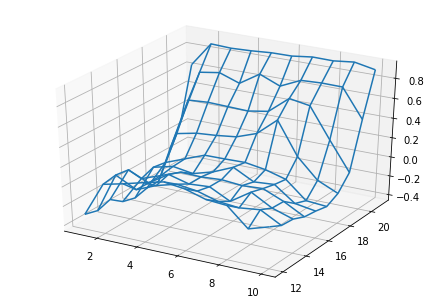

Q-value without Usable Ace


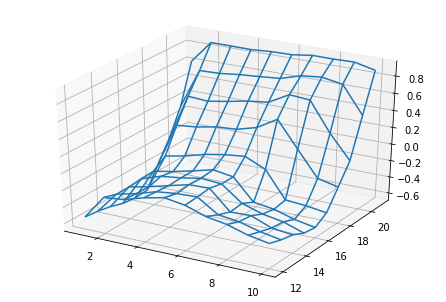

Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)


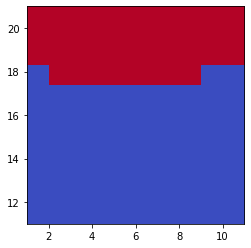

Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)


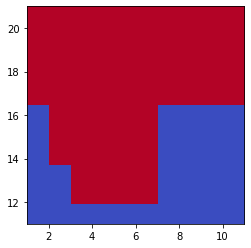

In [9]:
print("Q-value with Usable Ace")
plot_q_val(agent, usable_ace=True)
print("Q-value without Usable Ace")
plot_q_val(agent, usable_ace=False)
print("Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)")
usable_result = plot_action(agent, usable_ace=True)
print("Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)")
no_usable_result = plot_action(agent, usable_ace=False)

----
## 9. 과제

### 목표 
위 코드로부터 최적 Policy를 학습시킨 Agent를 사용하여, 블랙잭 게임을 시뮬레이션한 뒤 승률을 계산.

### 초기 설정
 - 플레이어는 1,000,000번의 에피소드로부터 최적 Policy를 학습
 - 플레이어의 초기 자금 : 10,000 달러
 - 플레이어는 게임 참가 시 10 달러를 지불, 결과에 따라 금액을 획득
     - 승리 시 : 20 달러 획득
     - 무승부 시 : 10 달러 획득
     - 패배 시 : 0 달러 획득

### 요구사항
 - 플레이어와 딜러가 1,000번의 게임을 진행
 - 1,000번의 게임 후 플레이어의 승률을 계산
 - 매 게임 별 플레이어의 소지금 변화를 그래프로 시각화

#### * HINT : MonteCarlo 클래스의 generate_episode(), train() 메소드를 참고할 것
----
### (과제 1) 1,000번의 게임 진행

========== Playing game :  10  ===========
========== Playing game :  20  ===========
========== Playing game :  30  ===========
========== Playing game :  40  ===========
========== Playing game :  50  ===========
========== Playing game :  60  ===========
========== Playing game :  70  ===========
========== Playing game :  80  ===========
========== Playing game :  90  ===========
========== Playing game :  100  ===========
========== Playing game :  110  ===========
========== Playing game :  120  ===========
========== Playing game :  130  ===========
========== Playing game :  140  ===========
========== Playing game :  150  ===========
========== Playing game :  160  ===========
========== Playing game :  170  ===========
========== Playing game :  180  ===========
========== Playing game :  190  ===========
========== Playing game :  200  ===========
========== Playing game :  210  ===========
========== Playing game :  220  ===========
========== Playing game :  230  =========

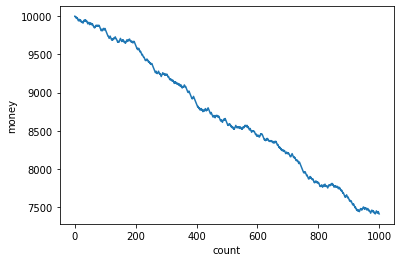

In [10]:
import pandas as pd
TOTALWIN=0
TOTALLOSE=0
TOTALDRAW=0
############### 코드 작성 ##############################
class MC_play(object):
    def generate_game(self, dealer: Dealer, agent: Agent, deck: Deck):
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            state = (sums, bool(agent.usable_ace), dealer.show())

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action =agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        return episode

    def play(self, dealer: Dealer, agent: Agent, deck: Deck, it=1000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        global TOTALWIN
        global TOTALLOSE
        global TOTALDRAW
        result = str()
        money = 10000
        data = {
            'play' : [0],
            'money' : [10000]
        }
        graph_pd = pd.DataFrame(data)
        
        for i in range(it):
            count += 1
            episode = self.generate_game(dealer, agent, deck)
            new_data = {
                'play' : count,
                'money' : money
            }
            graph_pd=graph_pd.append(new_data, ignore_index=True)
            money -= 10

            if episode[-1][-1] == 1:
                win += 1
                money += 20
            elif episode[-1][-1] == 0:
                money += 10
                draw += 1
            else:
                loss += 1
                

            if count % 10 == 0 and verbose == True:
                TOTALWIN += win
                TOTALLOSE += loss
                TOTALDRAW += draw
                print("========== Playing game : ", count, " ===========")
                win = 0
                loss = 0
                draw = 0
                if count == 1000:
                    print("money :", money)
                    plt.plot('play', 'money', data=graph_pd)
                    plt.xlabel('count')
                    plt.ylabel('money')
                    plt.show()
                    
            

                

                
mc = MC_play()
results=mc.play(dealer, agent, deck, it=1000)

########################################################
#시각화도 같이 진행했습니다.

### (과제 2) 플레이어의 승률을 계산

In [11]:
############### 코드 작성 ##############################
print("Total win rate : {:.3f}%".format(TOTALWIN / (TOTALWIN + TOTALLOSE) * 100))
print(" -- TOTAL Games WIN :", TOTALWIN, "DRAW :", TOTALDRAW, "LOSS :", TOTALLOSE)





########################################################

Total win rate : 36.111%
 -- TOTAL Games WIN : 338 DRAW : 64 LOSS : 598


### (과제 3) 플레이어의 소지금 변화를 그래프로 시각화

========== Playing game :  10  ===========
========== Playing game :  20  ===========
========== Playing game :  30  ===========
========== Playing game :  40  ===========
========== Playing game :  50  ===========
========== Playing game :  60  ===========
========== Playing game :  70  ===========
========== Playing game :  80  ===========
========== Playing game :  90  ===========
========== Playing game :  100  ===========
========== Playing game :  110  ===========
========== Playing game :  120  ===========
========== Playing game :  130  ===========
========== Playing game :  140  ===========
========== Playing game :  150  ===========
========== Playing game :  160  ===========
========== Playing game :  170  ===========
========== Playing game :  180  ===========
========== Playing game :  190  ===========
========== Playing game :  200  ===========
========== Playing game :  210  ===========
========== Playing game :  220  ===========
========== Playing game :  230  =========

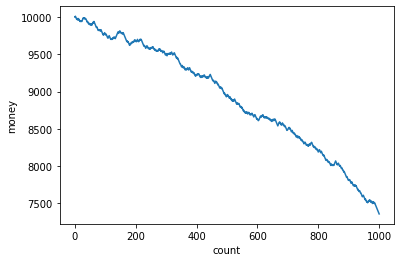

In [12]:
############### 코드 작성 ##############################
results=mc.play(dealer, agent, deck, it=1000)
########################################################

## 추가 과제 : 플레이어의 승률 높이기
State를 수정하여 승률이 더 높은 policy를 찾기

기존 코드의 수정 필요
 - 딜러는 게임이 끝났을 때, 남은 카드의 수를 확인
 - 15장 이상이라면 해당 덱을 다음 게임에서 그대로 사용
 - 15장 미만이라면 52장의 셔플된 새로운 카드를 기존 덱에 추가



In [ ]:
############### 코드 작성 ##############################


########################################################

---
### 참고자료
[1] Reinforcement Learning - An Introduction (Richard S. Sutton, Andreow G. Barto), 2nd edition, p.120-124 https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf <br>
[2] matplotlib.pyplot.plot Documentation, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html <br>
[3] matplotlib.pyplot.plot Examples https://matplotlib.org/tutorials/introductory/pyplot.html